# Exploring Topic and Word Relationships

Here we explore different ways that the the newstest 2015 dataset can be looked at.

In [1]:
import math

def read_file(file_path, max_amount=math.inf):
    """
    Reads a number of lines from file and return list of lines
    :param file_path:
    :param max_amount:
    :return: list[str]
    """
    line_list = []

    with open(file=file_path) as f:
        curr_idx = 0
        while curr_idx < max_amount:
            line_list.append(f.readline())
            curr_idx += 1

    return line_list

print("Loading file")
l_raw = read_file('./trg.shuf', 1000000)
print("Finished loading in file")

Loading file
Finished loading in file


In [2]:
def import_vocab(vocab_file_path):
    vocab = []
    with open(file=vocab_file_path) as f:
        curr_idx = 0
        max_amount = 5000000
        lines = f.readlines()
        for line in lines:
            l = line.split()
            if len(l) == 2:
                vocab.append(l[0])
                curr_idx += 1
    return vocab

print("Loading vocab")
target_vocab = import_vocab("./lm.vocab.txt")
print("Loaded vocab. It is of size: " + str(len(target_vocab)))

target_vocab_dic = {}
for w in target_vocab:
    target_vocab_dic[w] = 0


Loading vocab
Loaded vocab. It is of size: 34909


In [3]:
import math
import pandas as pd
from collections import Counter
import operator
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
from gensim import corpora
nltk.download('words')
from nltk.corpus import words
import enchant


d = enchant.Dict("en_US")

wn_lemmas = set(words.words())




def process_word(word, remove_stop=True, lemmatize_and_morph=True):
    """
    Returns process word
    :param word:
    :return: str word
    """
    # lower
    word = word.lower()
    
    # Remove symbols
    if len(word) < 3:
        return None
    
    # Get morph
    if lemmatize_and_morph is True:
        t_word = wn.morphy(word)
        if t_word is not None:
            word = t_word

        # Get lemma
        word = WordNetLemmatizer().lemmatize(word)
    
    # Remove stop
    if remove_stop is True and word in en_stop:
        return None
    return word


def preprocess_all_words(word_list):
    ret = []
    for line in word_list:
        temp = []
        for word in line:
            w = process_word(word, remove_stop=True, lemmatize_and_morph=False)
            if w is not None:
                temp.append(w)
        ret.append(temp)
    return ret


def process_bpe(line_list, seq="@@", rm_words=["\n"], lemmatize_and_morph=True, vocab_dictionary=None):
    """
    Transforms line list form read_file to list[list[str=words]], and bpe words merged together
    :param line_list:
    :param seq:
    :param rm_words:
    :return: list[list[str=words]]
    """
    word_to_bpe_mapping = {}  # word -> [bpe1, bpe2, ...]
    
    full_word_list = []
    for line in line_list:
        temp_words = line.split()
        full_words = []
        idx = 0
        while idx < len(temp_words):
            if temp_words[idx].endswith(seq):
                temp_str = ""
                temp_mapping = []
                while temp_words[idx].endswith(seq):
                    addition = temp_words[idx][:-(len(seq))]
                    if vocab_dictionary is not None:
                        if addition in vocab_dictionary:
                            temp_str += addition
                            temp_mapping.append(addition)
                    else:
                        temp_str += addition
                    idx += 1
                addition = temp_words[idx]
                if vocab_dictionary is not None:
                    if addition in vocab_dictionary:
                        temp_str += addition
                        temp_mapping.append(addition)
                else:
                    temp_str += addition
                
                if temp_str not in rm_words:
                    w = process_word(temp_str, lemmatize_and_morph=lemmatize_and_morph)
                    if w is not None:
                        full_words.append(w)
                        if w not in word_to_bpe_mapping:
                            word_to_bpe_mapping[w] = []
                        word_to_bpe_mapping[w].extend(temp_mapping)
                idx += 1
            else:
                if temp_words[idx] not in rm_words:
                    if vocab_dictionary is not None:
                        if temp_words[idx] in vocab_dictionary:
                            w = process_word(temp_words[idx], lemmatize_and_morph=lemmatize_and_morph)
                            if w is not None:
                                full_words.append(w)
                                if w not in word_to_bpe_mapping:
                                    word_to_bpe_mapping[w] = []
                                word_to_bpe_mapping[w].extend([w])
                    else:
                        w = process_word(temp_words[idx], lemmatize_and_morph=lemmatize_and_morph)
                        if w is not None:
                            full_words.append(w)
                            if w not in word_to_bpe_mapping:
                                word_to_bpe_mapping[w] = []
                            word_to_bpe_mapping[w].extend([w])

                idx += 1
        full_word_list.append(full_words)
    return full_word_list, word_to_bpe_mapping


def process_bpe_to_list(line_list, vocab_dictionary, unk_token="<UNK>"):
    """
    Transforms line list to word list.
    """
    full_word_list = []
    full_word_list_no_UNK = []
    
    for line in line_list:
        temp_words = line.split()
        temp_new_line = []
        temp_new_unk_line = []
        
        for word in temp_words:
            if word in vocab_dictionary:
                temp_new_line.append(word)
                if word not in en_stop and len(word) > 2:
                    temp_new_unk_line.append(word)
            else:
                temp_new_line.append(unk_token)
                
        full_word_list.append(temp_new_line)
        full_word_list_no_UNK.append(temp_new_unk_line)
        
    return full_word_list, full_word_list_no_UNK


def get_word_count(word_list):
    """
    Returns word count.
    :param word_list:
    :return: List[(str=word, int=count)]
    """
    word_count = {}
    for line in word_list:
        for word in line:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    return sorted(word_count.items(), key=operator.itemgetter(1))





num_topics = 5

import random
l = random.sample(l_raw, 50000)

print("Started training step")

wl, word_to_bpe_mapping_small  = process_bpe(line_list=l, vocab_dictionary=target_vocab_dic)
#wl, wl_clean = process_bpe_to_list(line_list=l, vocab_dictionary=target_vocab_dic, unk_token="<UNK>")
print("Vocab size train: " + str(len(get_word_count(word_list=wl))))

wl_full, word_to_bpe_mapping = process_bpe(line_list=l_raw, lemmatize_and_morph=False, vocab_dictionary=target_vocab_dic)
#wl_full, wl_full_clean = process_bpe_to_list(line_list=l_raw, vocab_dictionary=target_vocab_dic, unk_token="<UNK>")
vocab_size_full = len(get_word_count(word_list=wl_full))
print("Vocab size full: " + str(vocab_size_full))

dictionary = corpora.Dictionary(wl_full)
print("Finished Dictionary")

for w in word_to_bpe_mapping_small:
    if w in word_to_bpe_mapping:
        word_to_bpe_mapping[w].extend(word_to_bpe_mapping_small[w])
    else:
        word_to_bpe_mapping[w] = word_to_bpe_mapping_small[w]
print("Finished word2bpe mapping")



[nltk_data] Downloading package wordnet to /home/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/nikita/nltk_data...
[nltk_data]   Package words is already up-to-date!


Started training step
Vocab size train: 38340
Vocab size full: 264962
Finished Dictionary
Finished word2bpe mapping


In [4]:
def get_topics_lda(word_list, dictionary, num_topics):
    corpus = [dictionary.doc2bow(text) for text in word_list]
    print("Finished corpus")
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=4)
    print("Topics: ")
    for topic in topics:
        print(topic)

    return topics, ldamodel, corpus, dictionary

t, ldamodel,_, dictionary = get_topics_lda(word_list=wl, dictionary=dictionary, num_topics=num_topics)

Finished corpus
Topics: 
(0, '0.014*"http" + 0.009*"2015" + 0.006*"2010" + 0.005*"2014"')
(1, '0.006*"also" + 0.006*"one" + 0.005*"say" + 0.005*"year"')
(2, '0.004*"woman" + 0.003*"version" + 0.003*"role" + 0.003*"address"')
(3, '0.007*"hotel" + 0.007*"room" + 0.006*"2016" + 0.004*"currently"')
(4, '0.006*"post" + 0.005*"may" + 0.005*"page" + 0.005*"2009"')


# Vocab Splitting

Here we get the vocab for each topic.

In [20]:
def get_representatives_lda(word_list, lda_model, dictionary, num_topics=10):
    max_line = [[]] * num_topics
    max_class = [0] * num_topics 
    class_vocab = {i:{} for i in range(0, num_topics)}
    docs = [[]] * num_topics
    
    for line, idx in zip(word_list, range(len(word_list))):
        #print(line)
        new_doc_bow = dictionary.doc2bow(line)
        s = ldamodel.get_document_topics(new_doc_bow)
        s.sort(key=lambda x: x[1])
        t_max_class, t_max_perc = s[-1]
        docs[t_max_class].append(line)
        
        for word in line:
            if word in class_vocab[t_max_class]:
                class_vocab[t_max_class][word] += 1
            else:
                class_vocab[t_max_class][word] = 1
        
        if max_class[t_max_class] < t_max_perc:
            max_class[t_max_class] = t_max_perc
            max_line[t_max_class] = line
        
        if idx % 100000 == 0:
            print("Representatives: " + str(idx))
        
    print("Finished representatives")
    return max_line, max_class, class_vocab, docs


_, _, class_vocab, doc_classes = get_representatives_lda(wl_full, ldamodel, dictionary, num_topics=num_topics)

Representatives: 0
Representatives: 100000
Representatives: 200000
Representatives: 300000
Representatives: 400000
Representatives: 500000
Representatives: 600000
Representatives: 700000
Representatives: 800000
Representatives: 900000
Finished representatives


In [22]:
# Rrocess class vocab with word2bpe
def process_word2bpe_class_vocab(class_vocab, word2bpe):
    new_class_vocab = {i:{} for i in range(0, num_topics)}
    for topic in range(num_topics):
        for word in class_vocab[topic]:
            for bpe_w in word2bpe[word]:
                if bpe_w in new_class_vocab[topic]:
                    new_class_vocab[topic][bpe_w] += 1
                else:
                    new_class_vocab[topic][bpe_w] = 1
    return new_class_vocab

class_vocab = process_word2bpe_class_vocab(class_vocab, word_to_bpe_mapping)
print("Finished bpe2word")

Finished bpe2word


In [23]:


# max_l, max_c, class_vocab = get_representatives_lda(wl, ldamodel, dictionary)
"""
for idx in range(len(max_l)):
    print("\n")
    print("\n")
    print(max_c[idx])
    print(max_l[idx])
"""  

# get overlap
#num_topics = 20

import numpy as np


def get_overlap_matrix(class_vocab, num_topics):
    over_lap_matrix = np.zeros((num_topics, num_topics))
    over_lap_vocab = {}
    
    for c in range(0, num_topics):
        for c2 in range(0, num_topics):
            # Skip self
            if c2 >= c:
                continue
            # overlap
            words_in_c2_and_c1 = 0
            total_words_c2 = 0
            
            for word in class_vocab[c2]:
                if word not in over_lap_vocab:
                    over_lap_vocab[word] = np.zeros((num_topics, num_topics))
                
                total_words_c2 += 1 
                if word in class_vocab[c]:
                    words_in_c2_and_c1 += 1
                    over_lap_vocab[word][c, c2] = 1
            # Normalize        
            c_factor = len(class_vocab[c])/(len(class_vocab[c2]) + len(class_vocab[c]))
            c2_factor = len(class_vocab[c2])/(len(class_vocab[c2]) + len(class_vocab[c]))
            over_lap_matrix[c, c2] = (words_in_c2_and_c1/len(class_vocab[c2])) * c2_factor + (words_in_c2_and_c1/len(class_vocab[c])) * c_factor
    
    return over_lap_matrix, over_lap_vocab


over_lap_matrix, over_lap_vocab = get_overlap_matrix(class_vocab, num_topics)

over_lap_sum = 0
over_lap_count = 0
for c in range(0, num_topics):
    for c2 in range(0, num_topics):
        # Skip self
        if c2 >= c:
            continue
        over_lap_sum += over_lap_matrix[c, c2]
        over_lap_count += 1
        
over_lap_avg = over_lap_sum/over_lap_count

print("Overlap Matrix of Vocab")
print(pd.DataFrame(over_lap_matrix))
print("\n")

print("Average overall")
print(over_lap_avg)

print("\n")
print("Max")
print(np.max(over_lap_matrix))
      

Overlap Matrix of Vocab
          0         1         2         3    4
0  0.000000  0.000000  0.000000  0.000000  0.0
1  0.913252  0.000000  0.000000  0.000000  0.0
2  0.908656  0.908231  0.000000  0.000000  0.0
3  0.923839  0.930268  0.915557  0.000000  0.0
4  0.915488  0.924380  0.907934  0.961788  0.0


Average overall
0.9209392734759568


Max
0.9617878827024933


# Results



## LDA

### 20 Topics, 50000 clustering, 5 million testing:

Without stop words, after pbe processing, overall average 32.8% (max 42.5%).

### 5 Topics, 50000 clustering, 5 million testing:

Without stop words, after pbe processing, overall average 21.4% (max 29.7%).

### 5 Topics, 50000 clustering, 1 million testing, full bpe vocab:

Training without stop word, overall avg 95%, (max 96%).

### 5 topics, 50000 clustering, 1 million testing, vocab only if subword in bpe:

Without stop words, after pbe processing, overall average 34% (max 42.9%).

### 5 topics, 50000 clustering, 1 million testing, vocab only if subword in bpe and English (wordnet):

Without stop words, after pbe processing, overall average 36.6% (max 42.1%).

### 5 topics, 50000 clustering, 1 million testing, vocab only if subword in bpe and English (Enchant):

Without stop words, after pbe processing, overall average 58.4% (max 66%).

### 5 Topics, 50000 clustering, 1 million testing, word2bpe:

Training without stop word, overall avg 92%, (max 96%).

# TODO DEBUG Word2bpe


### TODO: 10 Topics, full bpe vocab

# Exploring vocab overlap

In [24]:
vocab_overlap_list = [(word, np.sum(over_lap_vocab[word])) for word in over_lap_vocab]
sort_vocab_overlap = sorted(vocab_overlap_list, key=lambda tup: tup[1])

print("Top 100 overlapping words: ")
print(sort_vocab_overlap[-100:-1])




Top 100 overlapping words: 
[('vity', 10.0), ('determines', 10.0), ('accessibility', 10.0), ('jugend', 10.0), ('recipient', 10.0), ('lodged', 10.0), ('in-depth', 10.0), ('2371', 10.0), ('varo', 10.0), ('legendary', 10.0), ('dary', 10.0), ('wide-ranging', 10.0), ('attracting', 10.0), ('cambridge', 10.0), ('stol', 10.0), ('depart', 10.0), ('usion', 10.0), ('lush', 10.0), ('connectivity', 10.0), ('Hans', 10.0), ('world-class', 10.0), ('insofar', 10.0), ('query', 10.0), ('abdullah', 10.0), ('seychelles', 10.0), ('lincoln', 10.0), ('Demo', 10.0), ('forwarding', 10.0), ('intercultural', 10.0), ('offline', 10.0), ('sqm', 10.0), ('reira', 10.0), ('meditation', 10.0), ('poo', 10.0), ('no-one', 10.0), ('resume', 10.0), ('palaces', 10.0), ('lend', 10.0), ('CHF', 10.0), ('praxis', 10.0), ('fake', 10.0), ('AVI', 10.0), ('instances', 10.0), ('rebuilding', 10.0), ('atus', 10.0), ('fte', 10.0), ('safeguards', 10.0), ('shield', 10.0), ('stedt', 10.0), ('2025', 10.0), ('urls', 10.0), ('breed', 10.0), ('

# Overlap Distribution

dict_items([(0.0, 636), (1.0, 886), (3.0, 1355), (6.0, 2550), (10.0, 14650)])
20077


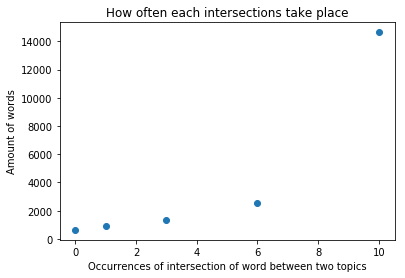

In [26]:
over_lap_distribution = {}
for word, count in sort_vocab_overlap:
    if count in over_lap_distribution:
        over_lap_distribution[count] += 1
    else:
        over_lap_distribution[count] = 1

over_lap_distribution = over_lap_distribution.items()
print(over_lap_distribution)
print(sum([v[1] for v in over_lap_distribution]))

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*over_lap_distribution))
plt.title("How often each intersections take place")
plt.xlabel("Occurrences of intersection of word between two topics")
plt.ylabel("Amount of words")
plt.show()

# Vocab Size Comparison

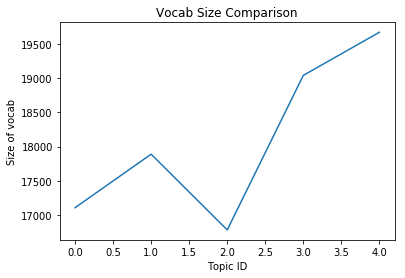

In [27]:
plt.title("Vocab Size Comparison")
plt.xlabel("Topic ID")
plt.ylabel("Size of vocab")
plt.plot([len(class_vocab[topic]) for topic in range(num_topics)])
plt.show()

# Vocab per Topic Average Frequency

In [29]:
def get_vocab_frequency(word_list, vocab_size_full):
    freq_vocab = {}
    for line in word_list:
        for word in line:
            if word not in freq_vocab:
                freq_vocab[word] = 1
            else:
                freq_vocab[word] += 1
    # Normalize
    for word in freq_vocab:
        freq_vocab[word] = freq_vocab[word]/float(vocab_size_full)
    return freq_vocab

def get_avg_freq_per_class(freq_vocab, class_vocab):
    avg_freq = [0] * num_topics
    total = [0] * num_topics
    for topic in range(num_topics):
        for word in class_vocab[topic]:
            total[topic] += 1
            avg_freq[topic] += freq_vocab[word]
    for t in range(num_topics):
        avg_freq[t] = avg_freq[t]/total[t]
    return avg_freq


vocab_freq = get_vocab_frequency(wl_full, vocab_size_full)
avg_freq = get_avg_freq_per_class(vocab_freq, class_vocab)

plt.title("Avg Vocab Frequency per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Average vocab frequency")
plt.plot([avg_freq[topic] for topic in range(num_topics)])
plt.show()

KeyError: '5'

# Word Explorer

In [33]:
def find_context(word_str):
    for line in wl_full:
        for word in line:
            if word == word_str:
                print(" ")
                print(line)
                new_doc_bow = dictionary.doc2bow(line)
                s = ldamodel.get_document_topics(new_doc_bow)
                s.sort(key=lambda x: x[1])
                t_max_class, t_max_perc = s[-1]
                print("Attributed to topic: " + str(t_max_class) + " with percentage: " + str(t_max_perc))

find_context("audi")


 
['audi', 'successful', 'china', '2007']
Attributed to topic: 3 with percentage: 0.24142404
 
['hofele-design', 'innovative', 'company', 't-range', 'car-accessories', 'international', 'markets', 'supply', 'important', 'car-producers', 'companies', 'worldwide', 'special', 'interest', 'goes', 'brands', 'audi']
Attributed to topic: 4 with percentage: 0.41900846
 
['audi', '77g']
Attributed to topic: 0 with percentage: 0.73065865
 
['mercedes-benz', 'ble', 'audi', 'ble', 'chrysler', 'crossfire', 'roadster', 'roof', 'systems', 'renault', 'gane', 'ble', 'volkswagen', 'new', 'beetle', 'ble', 'examples', 'current', 'production', 'reference', 'list']
Attributed to topic: 3 with percentage: 0.34194428
 
['front', 'seats', 'new', 'audi', 'photo', 'interior']
Attributed to topic: 1 with percentage: 0.36346945
 
['audi', 'urban', 'future', 'award', 'awarded', '2010', 'corporation', 'organized', 'exhibition', 'new', 'york', 'ideas', 'mobility', 'urbanism', 'future', 'audi', 'board', 'member', 'pete

 
['jüttner', 'technical', 'director', 'audi', 'sport', 'team', 'est', 'mans', 'certainly', 'exciting', 'race']
Attributed to topic: 3 with percentage: 0.4696214
 
['impressive', 'demonstration', 'audi', 'tdi', 'power']
Attributed to topic: 0 with percentage: 0.5004373
 
['thereby', 'audi', 'sticks', 'aesthetic', 'design', 'created', 'berlin', 'agency', 'neue', 'ale', 'orfish', 'ativ', 'technology', 'tvnext', 'solutions']
Attributed to topic: 0 with percentage: 0.3350186
 
['audi', 'june', '2007']
Attributed to topic: 2 with percentage: 0.55087066
 
['jar', 'well', 'regarded', 'previously', 'available', 'far', 'wer', 'range', 'engine', 'body', 'options', 'compared', 'german', 'rivals', 'bmw', '5eries', 'mercedes', 'class', 'audi']
Attributed to topic: 3 with percentage: 0.438261
 
['bmw', 'mercedes-benz', 'audi', 'reporting', 'expanding', 'sales', 'profits', 'year', 'led', 'largely', 'expanding', 'businesses', 'china']
Attributed to topic: 3 with percentage: 0.3640351
 
['great', 'year

Attributed to topic: 4 with percentage: 0.4710386
 
['audi', 'bmw', 'schmens', 'hausgeräte', 'gmbh', 'british', 'standards', 'institute', 'bsi', 'daimlerenz', 'deutsche', 'telekom', 'din', 'sap', 'ith', 'group', 'volkswagen', 'wavetek', 'gmbh', 'etc']
Attributed to topic: 3 with percentage: 0.534015
